In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import argparse
import sys
import numpy as np
sys.path.append('../../gears_temp/')
from gears import GEARS
from gears.inference import evaluate

from gears import PertData, GEARS
import scanpy as sc
import diffxpy.api as de

from scipy.stats import hypergeom
from sklearn.metrics import jaccard_score
from statsmodels.stats.multitest import multipletests

In [4]:
def make_gene_list_unique(adata):
    if adata.var['gene_name'].value_counts().max() == 1:
        return
    
    else:
        adata.var = adata.var.reset_index()
        adata.var['gene_name'] = adata.var['gene_name'].astype('string')
        adata.var = adata.var.set_index('gene_name')
        adata.var_names_make_unique()
        adata.var = adata.var.reset_index()
        adata.var = adata.var.set_index('gene')
        return

### DE Evaluation

In [5]:
def run_DE_test(pert, high_expression_filter, filter_level=0.01):
    ctrl_adata = adata[adata.obs['condition']=='ctrl']
    DE_adata = adata[adata.obs['condition'].isin(['ctrl', pert])]

    if high_expression_filter:
        high_expression_idx = np.where(adata.X.toarray().mean(0)>filter_level)[0]
        high_expression_genes = adata.var.index[high_expression_idx]
        ctrl_adata = ctrl_adata[:, high_expression_genes]
        DE_adata = DE_adata[:, high_expression_genes]


    ## First compute for true DE
    DE_adata.X = DE_adata.X.todense()
    true_df = DE_adata.to_df()
    true_df['condition'] = DE_adata.obs['condition']

    true_df_mean = true_df.groupby('condition').mean()

    slim_adata = sc.AnnData(DE_adata.X.toarray())
    slim_adata.obs = DE_adata.obs

    ctrl_test = de.test.rank_test(
        data=slim_adata,
        grouping="condition"
    )


    ## For perts in test

    genes = [g for g in pert.split('+') if g != 'ctrl']
    preds = gears_model.predict([genes], all_samples=True)['_'.join(genes)]

    if high_expression_filter:
        preds = preds[:, high_expression_idx]

    pred_adata = sc.AnnData(np.concatenate([ctrl_adata.X.toarray(), preds]))
    pred_adata.obs_names_make_unique()

    pred_adata.obs['condition']=['ctrl']*len(ctrl_adata) + [pert]*len(preds)

    for c in slim_adata.obs.columns:
        if c == 'condition':
            continue
        pred_adata.obs[c] = slim_adata.obs[c][0]


    pred_test  = de.test.rank_test(
        data=pred_adata,
        grouping="condition"
    )

    pred_df = pred_adata.to_df()
    pred_df['condition'] = pred_adata.obs['condition']

    pred_df_mean = pred_df.groupby('condition').mean()
    
    return ctrl_test, pred_test

def filter_summaries(ctrl_test, pred_test, abslogfc_thresh=1, qval_thresh=0.05):
    pred_summary = pred_test.summary()
    pred_summary['abs_log2fc'] = pred_summary['log2fc'].abs()

    ctrl_summary = ctrl_test.summary()
    ctrl_summary['abs_log2fc'] = ctrl_summary['log2fc'].abs()

    ctrl_subset = ctrl_summary[ctrl_summary['abs_log2fc']>1]
    ctrl_subset = ctrl_subset[ctrl_subset['qval']<0.05]

    pred_subset = pred_summary[pred_summary['abs_log2fc']>1]
    pred_subset = pred_subset[pred_subset['qval']<0.05]
    
    return ctrl_subset, pred_subset 

def get_p_val_jaccard(ctrl_subset, pred_subset):  
    y_true = set(ctrl_subset['gene'].values)
    y_pred = set(pred_subset['gene'].values)
    overlap = len(y_true.intersection(y_pred))
    jaccard = get_jaccard(y_true, y_pred)    

    M = len(ctrl_test.summary())
    N = len(pred_subset)
    n = len(ctrl_subset)
    k = overlap
    print(M, N, n, k)

    p_value = hypergeom.cdf(k-1, M, n, N)
    adjusted_p_value = multipletests(p_value, method='bonferroni')[1]
    
    #return (1-p_value, jaccard)
    return (adjusted_p_value, jaccard)
    
def get_jaccard(A, B):
    return (len(A.intersection(B))/len(A.union(B)))

In [6]:
adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hvg+perts.h5ad')
gene_name_dict = adata.var.loc[:,'gene_name'].to_dict()
gene_name_dict_inverse = {val:key for key, val in gene_name_dict.items()}

### Set up model and data split

In [10]:
jaccards = {}
p_vals = {}

In [ ]:
for seed in range(1,6):
    device =6
    dataset='norman'
    batch_size=32
    epoch = 15
    no_perturb = False
    naive=None
    model='gears'

    data_path = '/dfs/project/perturb-gnn/datasets/data/'
    pert_data = PertData(data_path[:-1]) # specific saved folder
    #pert_data.load(data_path = data_path + dataset) # load the processed data, the path is saved folder + dataset_name
    pert_data.load(data_name = dataset)
    pert_data.prepare_split(split = 'simulation', seed = seed)
    pert_data.get_dataloader(batch_size = batch_size, test_batch_size = batch_size)

    gears_model = GEARS(pert_data, device = 'cuda:' + str(device), 
                        weight_bias_track = False, 
                        proj_name = dataset, 
                        exp_name = str(model) + '_seed' + str(seed))
    gears_model.load_pretrained('../Evaluation/model_ckpt/norman_gears_run'+str(seed)+'_fix/')
  
    high_expression_filter = True
    filter_level = 0.01

    p_vals[seed] = {}
    jaccards[seed] = {}
    for key in pert_data.subgroup['test_subgroup'].keys():
        p_vals[seed][key] = []
        jaccards[seed][key] = []
        for pert in pert_data.subgroup['test_subgroup'][key]:
            print(pert)
            ctrl_test, pred_test = run_DE_test(pert, high_expression_filter, filter_level=filter_level)
            ctrl_subset, pred_subset = filter_summaries(ctrl_test, pred_test)
            p_val, jaccard = get_p_val_jaccard(ctrl_subset, pred_subset)
            p_vals[seed][key].append(p_val)
            jaccards[seed][key].append(jaccard)
            
    del(gears_model)

Found local copy...
These perturbations are not in the GO graph and is thus not able to make prediction for...
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:43
combo_seen2:19
unseen_single:36
Done!
Creating dataloaders....
Done!


CBL+PTPN9
1415 551 132 82
DUSP9+PRTG
1415 593 265 182
FOXL2+MEIS1
1415 691 161 128
CEBPB+OSR2
1415 776 382 334
JUN+CEBPB
1415 834 229 179
CDKN1C+CDKN1B
1415 624 129 114
CDKN1C+CDKN1A
1415 627 142 118
CDKN1B+CDKN1A
1415 608 141 123
C3orf72+FOXL2
1415 656 74 46
MAP2K6+SPI1
1415 477 115 78
DUSP9+MAPK1
1415 195 61 17
UBASH3B+OSR2
1415 524 70 59
DUSP9+ETS2
1415 281 133 86
ZNF318+FOXL2
1415 590 93 75
UBASH3B+PTPN9
1415 532 126 90
JUN+CEBPA
1415 915 425 308
MAPK1+PRTG
1415 279 166 83
KLF1+COL2A1
1415 702 152 112
PTPN12+OSR2
1415 540 48 38
POU3F2+FOXL2
1415 702 232 177
BCL2L11+TGFBR2
1415 382 18 10
CEBPB+CEBPA
1415 959 397 317
PTPN12+PTPN9
1415 546 143 99
FOSB+CEBPB
1415 802 347 237
BCL2L11+BAK1
1415 178 4 1
CBL+CNN1
1415 576 227 134
ZBTB10+PTPN12
1415 538 206 143
CBL+UBASH3B
1415 524 205 112
CEBPB+PTPN12
1415 679 153 129
CEBPB+MAPK1
1415 604 289 238
DUSP9+IGDCC3
1415 578 258 183
CBL+PTPN12
1415 536 141 73
SGK1+S1PR2
1415 676 238 187
DUSP9+KLF1
1415 578 207 126
CEBPE+SPI1
1415 773 484 341
CBL+

Found local copy...
These perturbations are not in the GO graph and is thus not able to make prediction for...
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:12
combo_seen1:52
combo_seen2:16
unseen_single:37
Done!
Creating dataloaders....
Done!


MAP2K3+SLC38A2
1415 237 17 4
MAPK1+PRTG
1415 581 166 126
MAP2K3+IKZF3
1415 391 142 71
MAPK1+IKZF3
1415 604 242 180
ETS2+CNN1
1415 620 59 50
CNN1+MAPK1
1415 540 89 55
CNN1+UBASH3A
1415 622 181 89
ETS2+MAPK1
1415 586 281 180
FOXA1+FOXL2
1415 748 192 158
ETS2+PRTG
1415 659 146 127
ETS2+IKZF3
1415 672 289 227
FOSB+IKZF3
1415 666 156 128
TGFBR2+ETS2
1415 550 59 40
SGK1+TBX3
1415 461 124 82
FOXA3+FOXA1
1415 753 232 193
ETS2+IGDCC3
1415 632 101 86
MAP2K6+IKZF3
1415 152 150 37
KLF1+FOXA1
1415 322 158 94
DUSP9+MAPK1
1415 632 61 48
DUSP9+ETS2
1415 703 133 119
ZNF318+FOXL2
1415 613 93 76
KLF1+BAK1
1415 287 67 45
IGDCC3+MAPK1
1415 565 123 92
JUN+CEBPA
1415 716 425 239
UBASH3B+UBASH3A
1415 535 52 40
MAP2K3+MAP2K6
1415 167 14 2
TMSB4X+BAK1
1415 482 7 2
BPGM+SAMD1
1415 695 149 113
ETS2+CEBPE
1415 762 285 252
POU3F2+FOXL2
1415 760 232 197
DUSP9+PRTG
1415 669 265 194
KIF18B+KIF2C
1415 505 8 6
CEBPB+CEBPA
1415 829 397 282
PTPN12+UBASH3A
1415 524 145 75
FOXL2+MEIS1
1415 717 161 136
MAPK1+TGFBR2
1415 469 

In [ ]:
#np.save('p_values_norman_filter_0.01_gears', p_vals)
#np.save('jaccards_norman_filter_0.01_gears', jaccards)

In [7]:
p_vals = np.load('/dfs/user/yhr/gears2/Evaluation/p_values_norman_filter_0.01_gears.npy',allow_pickle=True).item()
jaccards = np.load('/dfs/user/yhr/gears2/Evaluation/jaccards_norman_filter_0.01_gears.npy',allow_pickle=True).item()

In [15]:
tot_num_tests = 0
for setting in jaccards[1].keys():
    for seed in range(1,6):
        print(seed, setting, len(jaccards[seed][setting]))
        tot_num_tests += len(jaccards[seed][setting])

1 combo_seen0 9
2 combo_seen0 12
3 combo_seen0 4
4 combo_seen0 4
5 combo_seen0 3
1 combo_seen1 43
2 combo_seen1 52
3 combo_seen1 51
4 combo_seen1 52
5 combo_seen1 56
1 combo_seen2 19
2 combo_seen2 16
3 combo_seen2 19
4 combo_seen2 18
5 combo_seen2 18
1 unseen_single 36
2 unseen_single 37
3 unseen_single 35
4 unseen_single 37
5 unseen_single 40


In [16]:
jaccards_list = []

for k in jaccards.keys():
    jaccards_list.append(np.mean(np.hstack(list(jaccards[k].values()))))

In [17]:
split_key = 'combo_seen0'

def get_jaccards(split_key):
    jaccards_list = []

    for k in jaccards.keys():
        jaccards_list.append(np.mean(jaccards[k][split_key]))
        
    return jaccards_list

combo_seen2 = get_jaccards('combo_seen2')
print('combo_seen2')
print(combo_seen2)

combo_seen1 = get_jaccards('combo_seen1')
print('combo_seen1')
print(combo_seen1)

combo_seen0 = get_jaccards('combo_seen0')
print('combo_seen0')
print(combo_seen0)

combo_seen2
[0.202823495272181, 0.1822980839832596, 0.23754649106163644, 0.1643717276770979, 0.2084855778608513]
combo_seen1
[0.19716324638105612, 0.1820827122126891, 0.16632544568459223, 0.16329498274402438, 0.174281921860531]
combo_seen0
[0.20152161692340584, 0.1739900962568914, 0.14666980299866383, 0.16228680487918828, 0.2418153442479989]


### Visualizations

In [38]:
p_vals_all = {}
for k in p_vals[1].keys():
    p_vals_all[k] = []
    
for seed in range(1,6):
    for col in p_vals_all.keys():
        p_vals_all[col].extend(p_vals[seed][col])

In [39]:
dfs = []

for seed in range(1,6):
    df = pd.DataFrame.from_dict(p_vals[seed], orient='index').T
    df = df.melt().dropna()
    df['-log(p)'] = df.value.apply(lambda x: -np.log10(x+1e-20))
    df['condition'] = df['variable'].map({'combo_seen0':'0/2 Seen',
                                          'combo_seen1':'1/2 Seen',
                                          'combo_seen2':'2/2 Seen',
                                          'unseen_single':'0/1 Seen'})
    df['seed']=seed
    dfs.append(df)

dfs = pd.concat(dfs)

In [40]:
import matplotlib

font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

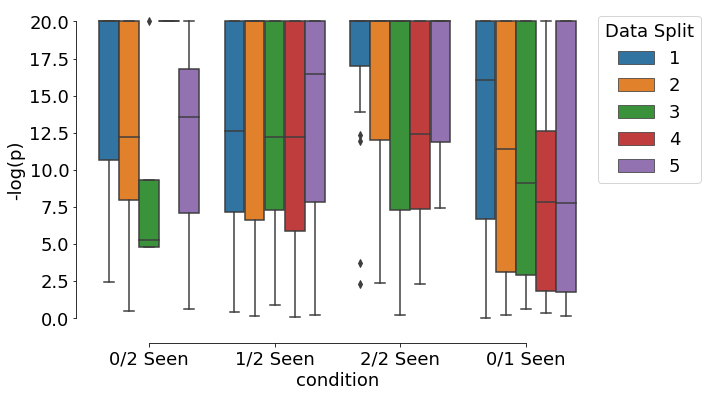

In [41]:
plt.figure(figsize=[9,6])
sns.boxplot(x="condition", y="-log(p)",
            hue="seed", 
            data=dfs)
sns.despine(offset=10, trim=True)

ax=plt.gca()
ax.legend(bbox_to_anchor=(1.0, 1.0), title='Data Split')

In [42]:
# Calculate group sizes
group_sizes = dfs.groupby(['condition', 'seed']).size()

# Define a function to apply to each row
def apply_func(row):
    group_size = group_sizes[row['condition'], row['seed']]
    if group_size < 10:
        return row['-log(p)']
    else:
        return np.nan

# Create the new column
dfs['new_logp'] = dfs.apply(apply_func, axis=1)


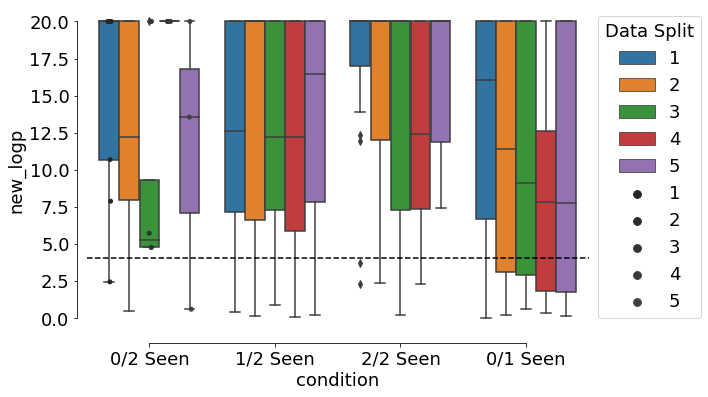

In [48]:
plt.figure(figsize=[9,6])
sns.boxplot(x="condition", y="-log(p)", hue="seed", data=dfs)
sns.stripplot(x="condition", y="new_logp", hue="seed", data=dfs, color=".25", dodge=True)
sns.despine(offset=10, trim=True)

ax=plt.gca()
ax.legend(bbox_to_anchor=(1.0, 1.0), title='Data Split')

plt.axhline(y=-np.log10(0.05/tot_num_tests), color='black', linestyle='--')
plt.savefig('DE_pvals.svg', bbox_inches='tight')